# Advanced Example: Simulation of Ticker Picker Portfolios
In this advanced example, we query the ticker-picker agents to generate a list of tickers to include in a portfolio $\mathcal{P}$ given an investment budget $\mathcal{B}$. We then compare the performance of our portfolio $\mathcal{P}$ (assuming random weights) to a portfolio consisting of `SPY` alone.

### Learning objectives
* __Prerequisites__: Load ticker-picker save file and out-of-sample market data
* __Task 1__: Generate a random ticker-picker portfolio.
    * `TODO`: Select your portfolio tickers
* __Task 2__: Simulate out-of-sample portfolio performance
    * `TODO`: Simulate out-of-sample portfolio performance
    * `TODO`: Visualize our portfolio versus SPY

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our lab problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl).

In [3]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-136/module-2/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-136/module-2/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-136/module-2`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-136/module-2/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-136/module-2/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-136/module-2/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CH

## Prerequisites: Load ticker-picker save file and out-of-sample market data
Let's begin by loading the [HDF5 encoded risk-blind saved file](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) generated in the alternative investment advanced example using [a `load(...)`  method exported by the JLD2.jl package](https://github.com/JuliaIO/JLD2.jl). First, we specify the path to the saved file in the `path_to_save_file::String` variable:

In [5]:
number_of_agents = 10000; # how many agents do we want
path_to_save_file = joinpath(_PATH_TO_DATA, "TickerPickerAgent-Simulation-State-ALT-RA-SPY-N-$(number_of_agents).jld2");

then [call the `load(...)` method exported by the JLD2.jl package](https://github.com/JuliaIO/JLD2.jl), which reads the binary saved file and returns the saved data as a dictionary; we assign the data to the `saved_state_dict::Dict{String, Any}` variable:

In [7]:
saved_state_dict = load(path_to_save_file);

### Set constant values
In the code block below, we set various constant values (and compute some derived constants) that we use in the tasks below. We generally access these values from the `saved_state_dict::Dict{String, Any}` by passing a `key::String` value to the saved data dictionary. Please see the comment beside the code line for more details about the value and what we'll use it for.

In [9]:
insampledataset = saved_state_dict["insampledata"]; # OHLC data 460 or so firms/ETFs
my_tickers = saved_state_dict["tickers"] |> sort; # *sorted* list of tickers we specified in the worked example
preferences_risk_blind = saved_state_dict["preferences_risk_blind"]; # prefs in the risk-blind case
preferences_risk_aware = saved_state_dict["preferences_risk_aware"]; # prefs in the risk-blind case
Δt = (1.0/252);
K = length(my_tickers); # how tickers (arms) do we have? 

### Out-of-sample price data
Next, we'll load out-of-sample daily price data to test the ticker-picker preferences.
We gathered daily open-high-low-close data for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2024` until `07-19-2024`, along with data for a few exchange-traded funds and volatility products during that time. We'll use this data in the subsequent tasks below, but we must load and clean it up first. 
* First, we'll load the data and remove tickers that do not have the maximum number of trading days. We'll store the cleaned data in the `dataset::Dict{String, DataFrame}` variable.
* Next, we'll get a list of all the tickers in the `dataset,` sort them alphabetically, and store them in the `all_tickers_array` variable.

In [11]:
original_dataset = MyOutOfSamepleMarketDataSet() |> x-> x["dataset"];

#### Clean the data
Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximum value, e.g., `AAPL,` and save that value in the `maximum_number_trading_days` variable:

In [13]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

* Second, let's iterate through our data and collect only those tickers with `maximum_number_trading_days::Int64` records. Save that data in the `outofsampledataset::Dict{String,DataFrame}` variable:

In [15]:
outofsampledataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        outofsampledataset[ticker] = data;
    end
end
outofsampledataset;

## Task 1: Generate a random ticker-picker portfolio
In this task, you will sample the agents and have them vote on what to include in your portfolio based on their analysis of the past data. The first thing we need to do is to select which preference dataset we want to sample, either the risk-blind or the risk-adjusted dataset. Let's specify this in the `preference_dataset` variable:

In [17]:
preference_dataset = preferences_risk_aware; # either preferences_risk_blind -or- preferences_risk_aware

Next, now that we have selected our preference dataset, i.e., our understanding of the past world, we sample that dataset using [a nested `for-loop`](https://docs.julialang.org/en/v1/base/base/#for) where we iterate over _all K_ tickers in the outer-loop and _all agents_ in the inner loop. Once we select a ticker (index `i`) and an agent (index `j`), we:
* We access the agent's belief about a ticker encoded as a [`Beta` distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Beta). From that, we extract the ($\alpha$,$\beta$) parameters, i.e., the number of times a ticker beat the alternative investment versus the number of times the agent lost versus the alternative investment, respectively.
* We then compute the agent's vote for the ticker by first computing the expected value for the ticker to beat the alternative investment. We then use this value to construct [a `Bernoulli` distribution](https://juliastats.org/Distributions.jl/latest/univariate/#Distributions.Bernoulli) and sample that distribution. It returns a value of `1` if the agent wants to include the ticker or `0` otherwise.
* Finally, we store the agent's vote (column) for the ticker (row) in the `votes::Array{Int64,2}` array. Each row corresponds to a ticker, while each column is the vote of an agent to include `1` or exclude `0` from the ticker.

In [19]:
votes = Array{Int64,2}(undef, K, number_of_agents);
for i = 1:K
    for j = 1:number_of_agents
        α, β = preference_dataset[i,j] |> d -> params(d);
        votes[i,j] = α/(α + β) |> θ -> Bernoulli(θ) |> d -> rand(d) |> vote -> trunc(Int64,vote);
    end
end
votes

29×10000 Matrix{Int64}:
 0  0  1  0  1  0  0  0  1  0  1  0  1  …  0  1  0  0  1  0  0  1  0  1  0  0
 0  1  0  0  0  1  0  0  0  1  0  0  1     0  0  0  0  0  0  0  1  1  0  0  1
 0  0  0  0  0  0  1  1  0  0  0  1  1     0  0  0  1  1  0  1  0  0  1  0  0
 0  1  0  0  0  0  0  0  1  1  1  0  0     0  1  0  0  0  0  0  0  0  0  1  1
 0  0  0  1  0  1  0  1  0  1  0  0  0     1  0  0  1  1  1  0  0  1  1  1  1
 1  0  0  1  0  0  0  0  0  0  1  1  0  …  0  0  1  0  0  1  0  0  0  0  0  1
 1  0  0  0  0  0  0  1  1  0  0  1  0     1  0  1  1  1  0  0  1  1  1  0  0
 1  1  1  0  0  1  0  0  0  0  1  0  1     1  0  0  1  1  1  0  0  0  0  1  0
 1  1  1  1  1  0  0  1  0  1  1  1  0     1  1  0  0  0  1  0  0  1  0  0  0
 1  0  0  1  0  0  0  0  0  1  1  1  1     0  0  0  0  0  1  1  1  1  1  0  1
 0  0  0  1  0  1  0  1  0  1  0  1  1  …  1  1  1  1  1  0  1  1  0  1  0  1
 1  1  0  1  0  1  1  0  1  1  0  1  1     1  0  1  0  0  1  1  1  0  1  1  1
 0  1  0  0  0  0  0  0  1  0  0  1  1  

Now that all the agents have voted, let's count the votes and see which tickers will be included in our portfolio. To get a better idea of the agent voting, let's build a table [using the `pretty_table(...)` function exported by the PrettyTables.jl package](https://github.com/ronisbr/PrettyTables.jl), which displays the ticker and the percentage vote tally.

#### Summary
`Unide` the code block below to see how we computed the ticker score and displayed it in a [table using the PrettyTables.jl package](https://github.com/ronisbr/PrettyTables.jl).
* The list of scores shows the fraction of the `number_of_agents::Int64` that voted to include a particular ticker symbol in the portfolio. Regardless of the adjustment for risk, `SPY` is always included by the agents (a consequence of the equality comparison when computing the reward).
* However, different lists are formulated depending on whether you use the risk-aware or risk-blind preference data.

In [21]:
let
    df = DataFrame()
    for i = 1:K
        score = sum(votes[i,:]) |> raw_score -> raw_score/number_of_agents;
        row_data = (
            ticker = my_tickers[i],
            score = score
        );
        push!(df, row_data);
    end
    pretty_table(df)
end

┌────────┬─────────┐
│ ticker │   score │
│ String │ Float64 │
├────────┼─────────┤
│   AAPL │    0.35 │
│    AMD │  0.3642 │
│    BAC │  0.3386 │
│      C │  0.3369 │
│  CMCSA │  0.5147 │
│    ECL │  0.3915 │
│     GS │  0.3458 │
│   INTC │  0.4297 │
│    JNJ │   0.631 │
│    JPM │  0.3625 │
│     KR │  0.6205 │
│    LMT │  0.5887 │
│    MET │  0.3413 │
│    MMM │  0.4632 │
│    MRK │   0.675 │
│   MSFT │  0.3819 │
│     MU │  0.3661 │
│   NFLX │  0.5214 │
│    NOC │  0.6389 │
│   NVDA │  0.3503 │
│    OXY │  0.3347 │
│    PEP │  0.5875 │
│    QQQ │  0.3724 │
│    SPY │  0.9991 │
│   SPYD │  0.3767 │
│    SRE │  0.5109 │
│   TSLA │  0.3385 │
│    UNH │  0.5721 │
│    WFC │  0.3447 │
└────────┴─────────┘


### TODO: Select your portfolio tickers
Given the scores above, we need a decision rule to pick which ticker to include in the portfolio $\mathcal{P}$; for example, is a simple majority, or a 2/3 majority, etc, required to accept a ticker? Let's specify the cutoff in the `cutoff::Float64` variable:

In [23]:
cutoff = 0.50; # Assume a 50% majority is required (adjust to what you want)

We accept the ticker if the score (percentage of the vote) exceeds the `cutoff::Float64` value specified above. If not, we reject the ticker. Let's populate the `portfolio_tickers::Array{Int64,1}` array with values of `1` and `0` indicating whether to include or reject a ticker, respectively, by iterating over the tickers using [a `for-loop`](https://docs.julialang.org/en/v1/base/base/#for)
* First, we compute a `score::Float64` value, the fraction of agents that voted to include the ticker in the portfolio. We then apply the decision rule and set a value for the `keep_flag::Int64` variable. Finally, we store that value in the `portfolio_tickers::Array{Int64,1}` array.

In [25]:
portfolio_tickers = Array{Int64,1}(undef, K);
for i = 1:K
    score = sum(votes[i,:]) |> raw_score -> raw_score/number_of_agents;
    keep_flag = 0; # default value, we reject this ticker
    if (score ≥ cutoff)
        keep_flag = 1;
    end
    portfolio_tickers[i] = keep_flag
end
number_of_tickers_we_keep = findall(x-> x == 1, portfolio_tickers) |> length;

To make our life easier below, let's build a `portfolio_ticker_index_lookup` table that maps the `ticker::String` symbol to the index of that ticker in our portfolio:

In [27]:
portfolio_ticker_index_lookup = Dict{String, Int64}();
idx = findall(x-> x == 1, portfolio_tickers)
for i ∈ eachindex(idx) 
    ticker = my_tickers[idx[i]];
    portfolio_ticker_index_lookup[ticker] = i;
end
portfolio_ticker_index_lookup

Dict{String, Int64} with 11 entries:
  "MRK"   => 5
  "UNH"   => 11
  "SPY"   => 9
  "SRE"   => 10
  "KR"    => 3
  "NOC"   => 7
  "LMT"   => 4
  "CMCSA" => 1
  "JNJ"   => 2
  "NFLX"  => 6
  "PEP"   => 8

Now that we have the `portfolio_tickers::Array{Int64,1}`, we can build a table to see what's included in our portfolio. A value of `1` in the `portfolio_tickers::Array{Int64,1}` array indicates we keep the ticker, `0` indicates we reject the ticker. 
* `Unhide` the code block below to see how we built a ticker inclusion table [using the `pretty_tables(...)` function exported by the PrettyTables.jl package](https://github.com/ronisbr/PrettyTables.jl)

In [29]:
let
    df = DataFrame();
    counter = 1;
    for i = 1:K
        keep_flag = portfolio_tickers[i];
        if (keep_flag == 1)
            ticker = my_tickers[i];
            row_data = (
                index = counter,
                ticker = ticker,
            );
            push!(df, row_data);
            counter += 1;
        end
    end
    pretty_table(df)
end

┌───────┬────────┐
│ index │ ticker │
│ Int64 │ String │
├───────┼────────┤
│     1 │  CMCSA │
│     2 │    JNJ │
│     3 │     KR │
│     4 │    LMT │
│     5 │    MRK │
│     6 │   NFLX │
│     7 │    NOC │
│     8 │    PEP │
│     9 │    SPY │
│    10 │    SRE │
│    11 │    UNH │
└───────┴────────┘


## Task 2: Simulate out-of-sample portfolio performance 
Now that we have asked the agents which tickers to include in our portfolio $\mathcal{P}$, let's run some simulations to see how this portfolio performs using an out-sample-data price set not used in agent training assuming random portfolio weighting factors. As an alternative, we'll compare our portfolio against the performance of `SPY.`

Let's begin by generating a random portfolio allocation using [the `Dirichlet` distribution exported by the Distributions.jl package](https://juliastats.org/Distributions.jl/latest/multivariate/#Distributions.Dirichlet). We store the random weights in the `ω::Array{Float64,1}` array, where we assume uniform values for the $\alpha_{i}$ parameters when initializing the distribution.

In [31]:
α = ones(number_of_tickers_we_keep);
ω = Dirichlet(α) |> d -> rand(d);

Next, convert the fractions $\omega_{i}$ into share counts $n_{i}$ at the beginning of the out-of-sample period. We know, from a `USD` balance, that:
$$
\begin{equation}
n_{i} = \frac{\omega_{i}\cdot{\mathcal{B}}}{S_{i,\circ}}
\end{equation}
$$
where $n_{i}$ denote the number of shares to purchase in period 1, $\omega_{i}$ denotes the fraction of the budget $\mathcal{B}$ used for ticker $i$ in the portfolio, assuming a `USD` basis, and $S_{i,\circ}$ denotes the share price of ticker $i$ when initializing the portfolio. We assume that we allocate the budget $\mathcal{B}$ at the beginning of the out-of-sample period and do not reallocate the portfolio weights. 
* We store the investment budget in the `total_budget_to_allocation::Float64` variable and the number of shares of each ticker in the `n::Array{Float64,1}` array. We compute the number of shares using the expression above, where we iterate over _all K_ possible tickers and check if the ticker is in our portfolio $\mathcal{P}$. If yes, we compute the share count using [the volume weighted average price](https://en.wikipedia.org/wiki/Volume-weighted_average_price) for period `1` and the random allocation fraction $\omega_{i}$.
* The `counter::Int64` value keeps track of the index of the ticker in the portfolio, i.e., the order of tickers in the portfolio (not the original list of tickers).

In [33]:
total_budget_to_allocation = 100.0; # Assume we have 100 USD to allocate
n = Array{Float64,1}(undef, number_of_tickers_we_keep);
counter = 1;
for i = 1:K
    if (portfolio_tickers[i] == 1)
        ticker = my_tickers[i];
        price_df = outofsampledataset[ticker];
        n[counter] = (total_budget_to_allocation*ω[counter])/(price_df[1,:volume_weighted_average_price]);
        
        # update -
        counter+=1;
    end
end

### TODO: Simulate out-of-sample portfolio performance
To compute the out-of-sample wealth, we first populate the `portfolio_vwap_array::Array{Float64,2}` array, which holds [the volume weighted average price (vwap)](https://en.wikipedia.org/wiki/Volume-weighted_average_price) prices for the tickers in portfolio $\mathcal{P}$. 
* We first initialize the `portfolio_vwap_array::Array{Float64,2}` array, then get the prices for the out-of-sample dataset by iterating over _all K_ tickers, checking if ticker `i` is in our portfolio; if yes, we get the `ticker::String` symbol, lookup the price data in the `outofsampledataset::Dict{String, DataFrame}` dictionary
* We then extract the [the volume weighted average price](https://en.wikipedia.org/wiki/Volume-weighted_average_price) for period `1:(maximum_number_trading_days)`, i.e., each trading period value that we have for each ticker in the `outofsampledataset::Dict{String, DataFrame}` dictionary and insert into the `portfolio_vwap_array` array.
* The `counter::Int64` value keeps track of the index of the ticker in the portfolio, i.e., the order of tickers in the portfolio (not the original list of tickers).

In [35]:
portfolio_vwap_array = Array{Float64,2}(undef, maximum_number_trading_days, number_of_tickers_we_keep);
counter = 1;
for i ∈ 1:K
    if (portfolio_tickers[i] == 1)
        ticker = my_tickers[i];
        price_df = outofsampledataset[ticker];
        for j = 1:(maximum_number_trading_days)
            portfolio_vwap_array[j, counter] = price_df[j,:volume_weighted_average_price];
        end

        # update -
        counter += 1;
    end
end
portfolio_vwap_array

137×11 Matrix{Float64}:
 43.4596  160.932  46.5957  460.215  …  173.162  469.898  75.8889  542.271
 42.7111  160.88   46.0657  460.303     171.861  468.554  76.1756  545.744
 43.0279  160.868  46.002   455.862     169.222  468.078  76.3709  537.545
 43.5595  160.955  45.8505  457.111     168.937  471.969  76.7536  535.583
 43.1703  161.675  45.9756  455.556     166.859  473.537  76.4278  536.943
 43.3871  161.782  46.1878  456.25   …  166.937  475.682  76.1686  537.708
 43.1608  161.177  45.797   452.43      165.738  475.315  74.9765  538.47
 43.0797  162.171  45.9349  461.115     166.733  476.587  75.3558  520.264
 43.0434  160.869  46.3246  459.084     166.189  474.914  74.6333  519.816
 42.4983  160.549  46.6184  457.76      166.296  471.773  73.8609  526.437
 42.4251  160.677  45.9879  457.875  …  166.519  474.746  73.0952  509.114
 43.0692  161.369  45.8891  458.162     166.128  479.967  72.8958  508.07
 43.6322  162.467  45.9774  458.946     165.443  483.678  71.7711  508.718
  ⋮

We compare the portfolio performance against `SPY,` so let's get the index of `SPY` in our portfolio using the `portfolio_ticker_index_lookup::Dict{String, Int64}` lookup dictionary constructed above, and store this value in the `index_SPY::Int64` variable:

In [37]:
index_SPY = portfolio_ticker_index_lookup["SPY"]; # index of SPY in our portfolio

Finally, we can compute the performance of our portfolio and store this in the `wealth_array::Array{Float64,2}` variable. To do this, we iterate through each trading period in the out-of-sample dataset [using a `for-loop`](https://docs.julialang.org/en/v1/base/base/#for), where for each period, we:
* Compute the scalar product between the share count vector $n$ and [the vwap](https://en.wikipedia.org/wiki/Volume-weighted_average_price) at time `t` using [the `dot(...)` function exported by the built-in Julia LinearAlgebra package.](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.dot) Next, we compute the wealth associated with the `SPY` only portfolio, where we assume that the entire `total_budget_to_allocation` budget is invested in `SPY,` i.e., $\omega = 1$.
* Finally, we store portfolio wealth, and the `SPY` only wealth in the `wealth_array::Array{Float64,2}`, where each row is a time-point, column `1` is our portfolio, and column `2` is `SPY.`

In [39]:
wealth_array = Array{Float64,2}(undef, maximum_number_trading_days, 2)
for t = 1:maximum_number_trading_days
    wealth_value_P = dot(n,portfolio_vwap_array[t,:]) # our portfolio
    wealth_value_SPY = (total_budget_to_allocation/portfolio_vwap_array[1,index_SPY])*portfolio_vwap_array[t,index_SPY] # spy on its own
    wealth_array[t,1] = wealth_value_P
    wealth_array[t,2] = wealth_value_SPY
end
wealth_array

137×2 Matrix{Float64}:
 100.0     100.0
  99.9869   99.7139
  99.6884   99.6126
  99.998   100.441
  99.9624  100.774
  99.9998  101.231
  99.5327  101.153
 100.17    101.424
  99.5923  101.067
  99.2302  100.399
  99.0262  101.032
  99.1826  102.143
  99.3388  102.933
   ⋮       
  99.836   117.11
 100.136   117.806
  99.8249  118.146
  99.9739  118.345
 100.483   119.05
 100.833   118.776
 101.282   119.262
 101.015   119.581
 101.389   119.949
 103.298   118.871
 103.43    117.951
 102.967   117.118

### TODO: Visualize
`Unhide` the code block below to see how we plotted the wealth of our portfolio (blue line) and the `SPY` investment (red line) for the out-of-sample dataset. 
#### Summary
* Our portfolio allocation is random, i.e., we used [a Dirichlet distribution exported by the Distributions.jl package](https://juliastats.org/Distributions.jl/latest/multivariate/#Distributions.Dirichlet) to compute random weights for each of the assets. Thus, each time the notebook is refreshed, we will have a different wealth trajectory. However, there are some general things we can say. For example, there are $\omega$-vectors where our portfolio significantly outperforms `SPY`-alone (of course, the counter is also probably true). A better comparison would be to compute optimal weights $\omega_{i}$ values by solving the minimum variance allocation problem that we explored earlier (we leave this to you).
* Switching the `preference_dataset` variable from risk-blind to risk-aware leads to underperformance of the portfolio $\mathcal{P}$ relative to `SPY` alone. We expect that while the wealth generated by the risk-aware portfolio is lower, the variance of the performance will also be less. Thus, a risk-sensitive agent is willing to trade return for less uncertainty.

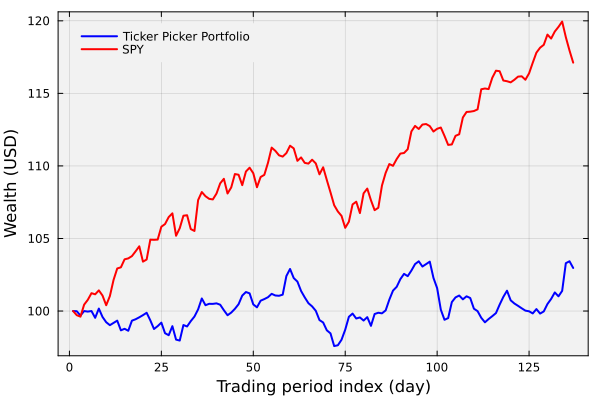

In [41]:
let
    plot(wealth_array[:,1], c=:blue, label="Ticker Picker Portfolio", lw=2, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    plot!(wealth_array[:,2], c=:red, label="SPY", lw=2)
    xlabel!("Trading period index (day)", fontsize = 18)
    ylabel!("Wealth (USD)", fontsize=18)
end

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.